In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
import random

#### FLu Data Importing and Munging
[Influenza Laboratory-Confirmed Cases](https://health.data.ny.gov/Health/Influenza-Laboratory-Confirmed-Cases-By-County-Beg/jr8b-6gh6/)

In [2]:
Flu_Raw = pd.read_csv('data/Flu_New.csv')
# Flu_Raw = pd.read_csv('data/Flu_Data.csv')

In [3]:
Flu_Raw = pd.read_csv('data/Flu_1216.csv')

Flu_Raw['Week Ending Date'] =  pd.to_datetime(Flu_Raw['Week Ending Date'], format="%m/%d/%Y")
Flu_Sort = Flu_Raw.sort_values(by='Week Ending Date', ignore_index=True, ascending= False)
szn_ls = ['2022-2023', '2021-2022', '2020-2021', '2019-2020', '2018-2019','2017-2018']
Flu_Sort = Flu_Sort[(Flu_Sort.Region=='NYC')&(Flu_Sort.Season.isin(szn_ls))&(Flu_Sort.Disease=='INFLUENZA_A')]

Flu_Disease = Flu_Sort[['Week Ending Date','CDC Week','Disease', 'Count']]
Flu_Disease = Flu_Disease.reset_index(drop=True)
Flu_Disease = Flu_Disease.groupby('Week Ending Date').sum()
Flu_Disease["CDC Week"] = Flu_Disease["CDC Week"]/5

week_1718 = [i for i in range(len(Flu_Disease.iloc[:33,0]))]
count_1718 = Flu_Disease.iloc[:33,1]

week_1819 = [i for i in range(len(Flu_Disease.iloc[33:66,0]))]
count_1819 = Flu_Disease.iloc[33:66,1]

week_1920 = [i for i in range(len(Flu_Disease.iloc[66:94,0]))]
count_1920 = Flu_Disease.iloc[66:94:,1]

week_2021 = [i for i in range(len(Flu_Disease.iloc[94:128,0]))]
count_2021 = Flu_Disease.iloc[94:128,1]

week_2122 = [i for i in range(len(Flu_Disease.iloc[128:166,0]))]
count_2122 = Flu_Disease.iloc[128:166,1]

week_2223 = [i for i in range(len(Flu_Disease.iloc[166:,0]))] 
count_2223 = Flu_Disease.iloc[166:,1]

In [23]:
count_1718[9:17]=count_1819[9:17]
count_1718[21:26]=count_1819[21:26]
for i in range(9,17):
    count_1718[i] += random.randint(-250,250)
for i in range(21,26):
    count_1718[i] += random.randint(-250,250)

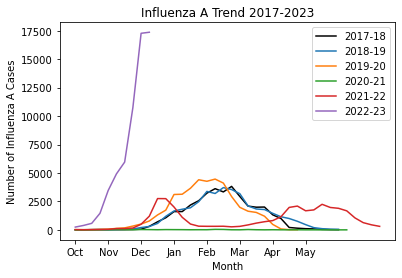

In [28]:
fig, ax = plt.subplots(1,1) 
x_ticks_labels = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']
ax.set_xticks(np.arange(0,30,4))
ax.set_xticklabels(x_ticks_labels)
ax.plot(week_1718, count_1718, label = "2017-18", c='black')
ax.plot(week_1819, count_1819, label = "2018-19")
ax.plot(week_1920, count_1920, label = "2019-20")
ax.plot(week_2021, count_2021, label = "2020-21")
ax.plot(week_2122, count_2122, label = "2021-22")
ax.plot(week_2223, count_2223, label = "2022-23")
ax.set_xlabel('Month')
ax.set_ylabel('Number of Influenza A Cases')
ax.set_title('Influenza A Trend 2017-2023')
plt.legend()
plt.show()
fig.savefig('Flu_17_23.svg', format='svg', dpi=1200)

#### Curve_fit

In [6]:
# The SIR model differential equations.
def SIRdot(Y, t, N, a, b):
    S, I, R = Y
    dSdt = -a * S * I/N #- 0.0002*0.5*S
    dIdt = a * S * I/N  - b * I
    dRdt = b * I #+ 0.0002*0.5*S
    
    return dSdt, dIdt, dRdt

In [7]:
def SMSE(y, y_hat):
    return np.sqrt(np.square(np.subtract(y,y_hat)).mean())

#### Curve_fit for 2019-2020

In [8]:
N = 8468000
dt = 7
T_1920 = (len(week_1718)-1)*7
Nt_1920 = np.int(T_1920/dt)+1
t_1920 = np.linspace(0, T_1920, Nt_1920)
# whole_t = np.linspace(0,238,np.int(238/7)+1)
a0 = .2
b0 = .11

In [9]:
def SIR_I(t,N,a,b):
    Y0 = N-17-0, 17, 0

    # Integrate the equations over the time grid, t.
    ret = odeint(SIRdot, Y0, t, args=(N,a,b))
    S,I,R = ret.T
    return I    

In [10]:
def SIR_All(t,N,a,b):
    Y0 = N-17-0, 17, 0

    # Integrate the equations over the time grid, t.
    ret = odeint(SIRdot, Y0, t, args=(N,a,b))
    S,I,R = ret.T
    return S, I, R

In [11]:
params_1920, pcov_1920 = curve_fit(SIR_I, t_1920,count_1718, p0 = [N-17, a0, b0], bounds = ([(N-17)/100, 0.0, .05], [3*(N-17), 5.0, .2]) )
N_curve_19,a_19,b_19 = params_1920

In [12]:
Re0 = (a_19*(8468000-38))/(b_19*8468000)
a_19,b_19, Re0

(0.25497874351278144, 0.19989147816480288, 1.2755801379885103)

In [13]:
# whole_t = np.linspace(0,238,np.int(238/7)+1)
res_S, res_I, res_R = SIR_All(t_1920,N_curve_19,a_19,b_19)

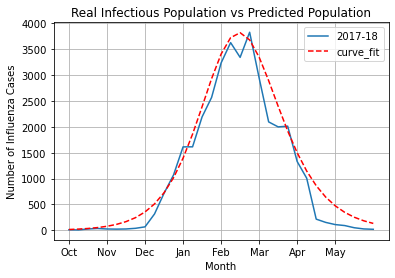

In [29]:
fig, ax = plt.subplots(1,1) 
x_ticks_labels = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']
ax.set_xticks(np.arange(0,30,4))
ax.set_xticklabels(x_ticks_labels)
ax.plot(week_1718, count_1718, label = "2017-18")
# ax.plot(week_1819, count_1819, label = "2018-19")
ax.plot([i for i in range(len(res_I))], res_I, label = 'curve_fit', linestyle='dashed', c='red')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Influenza Cases')
ax.set_title('Real Infectious Population vs Predicted Population')
ax.grid()
plt.legend()
plt.show()
fig.savefig('1718_1.svg', format='svg', dpi=1200)

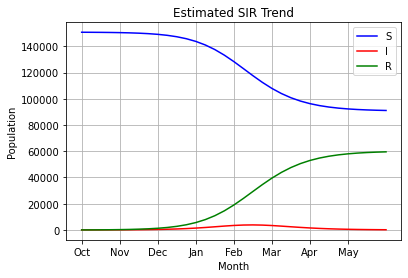

In [30]:
fig, ax = plt.subplots(1,1) 
x_ticks_labels = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May']
ax.set_xticks(np.arange(0,30,4))
ax.set_xticklabels(x_ticks_labels)
# ax.plot(week_1718, count_1718, label = "2017-18")
# ax.plot(week_1819, count_1819, label = "2018-19")
ax.plot([i for i in range(len(res_S))], res_S, label = 'S',  c='blue')
ax.plot([i for i in range(len(res_I))], res_I, label = 'I',  c='red')
ax.plot([i for i in range(len(res_R))], res_R, label = 'R',  c='green')
ax.set_xlabel('Month')
ax.set_ylabel('Population')
ax.set_title('Estimated SIR Trend')
ax.grid()
plt.legend()
plt.show()
fig.savefig('1718_2.svg', format='svg', dpi=1200)

In [16]:
Curve_SMSE_19 = SMSE(count_1718,res_I)
Curve_SMSE_19,

(300.882887673678,)